In [1]:
# IMPORTS AND UTILITY FUNCTIONS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler
from utils import *
from IPython.display import display, Markdown, HTML 
import markdown2


def get_demographics_data(only_eyetracking=True):
    df = pd.read_excel("./data/ICUdata/demographics.xlsx")
    df = df[['Participant Number', 'Easy icu A', 'Easy icua A', 'Hard icu B', 'Hard icua B', 'Scores', 'Scores.1', 'Scores.2', 'Scores.3']]
    df = df.rename(columns={"Participant Number": "participant", 'Easy icu A':0, 'Easy icua A':1, 'Hard icu B':2, 'Hard icua B':3, 
                            'Scores' : 'S0', 'Scores.1' : 'S1', 'Scores.2' : 'S2', 'Scores.3' : 'S3'})
    df = df.applymap(lambda x: x.replace(" ", "").replace("'", ""))
    
    if only_eyetracking:
        valid_participants = load_nested_dict('data/Processed').keys()
        df = df[df['participant'].isin(valid_participants)]
    return df

def compute_failure_interval_statistics(data, statistic):
    df = pd.DataFrame(columns=['participant', 'experiment', *sorted(ALL_WINDOW_PROPERTIES.keys()), 'total'])
    for participant, _data1 in data.items():
        for experiment, _data2 in _data1.items():
            start_time, finish_time =  _data2['start_time'], _data2['finish_time']
            stats, all_failure_intervals = [], []
            for task, _data3 in sorted(_data2['tasks'].items()):
                failure_intervals = [compute_time_intervals(x.failure, x.timestamp, start_time, finish_time).intervals for x in _data3.values()]
                failure_intervals = merge_intervals(failure_intervals) # merge them to get failures for a single task
                stats.append(statistic(failure_intervals, start_time, finish_time))
                all_failure_intervals.append(failure_intervals)
            total_failure = merge_intervals(all_failure_intervals) # overlapping total
            total_stat = statistic(total_failure, start_time, finish_time)
            df.loc[len(df)] = [participant, experiment[3:], *stats, total_stat]
    return df

def get_task_counts():
    df = get_demographics_data()
    exp = sorted(df[[0,1,2,3]].melt()['value'].unique())
    def gen():
        for column in df[[0,1,2,3]].columns:
            vcounts = df[column].value_counts().reset_index()
            value_counts = {k:0 for k in exp}
            value_counts.update(dict(zip(vcounts[vcounts.columns[0]], vcounts['count'])))
            yield value_counts
    return pd.DataFrame(gen())

pd.set_option("display.max_rows", 10)



## Distribution of performances
Plots show histogram over participants of their performance for each experiment. Red vertical line shows the mean.


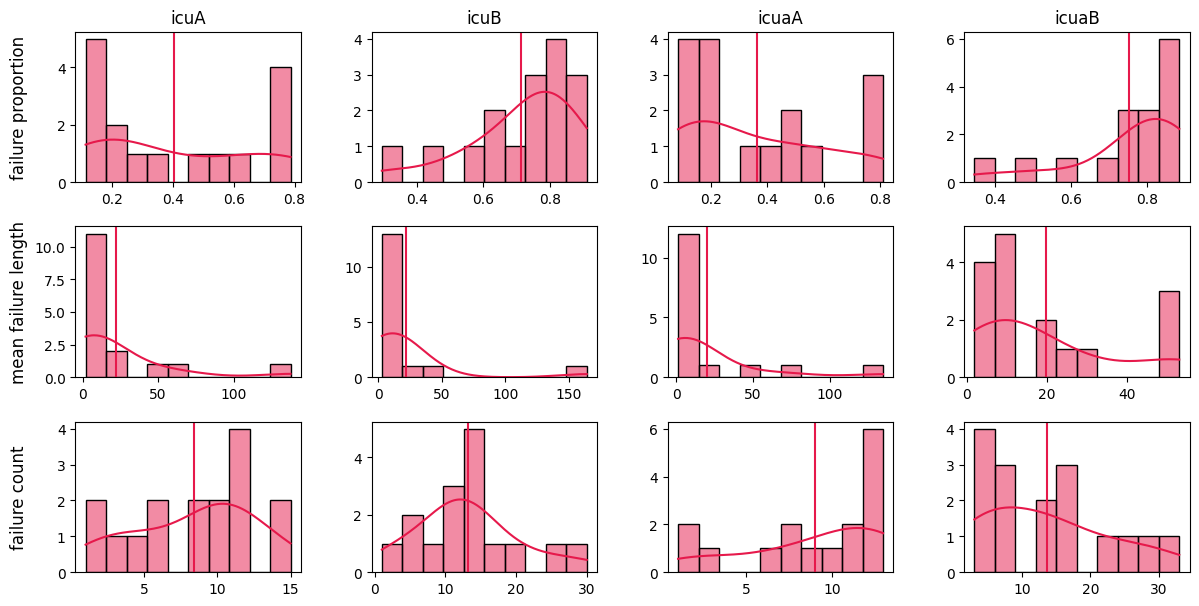

In [2]:
# VISUALISE PERFORMANCE DISTRIBUTIONS
data = load_nested_dict('data/Processed') 
df = compute_failure_interval_statistics(data, Statistics.compute_failure_proportion)
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(12,6)) # TODO no magic, compute nrows & ncols...
fig.tight_layout()

def visualise_performance_distribution(df, axes, titles=False, label=None):
    df = df[['participant', 'experiment', 'total']]
    df = df.pivot(index='participant', columns='experiment', values='total')
    exp = df.reset_index(drop=True).select_dtypes(include="number").columns.to_list()
    ax0 = axes.ravel()[0]
    ax0.text(-0.25, 0.5, label, transform=ax0.transAxes, rotation=90, va='center', ha='center', fontsize=12)

    for c, ax in zip(exp, axes.ravel()):
        sns.histplot(df[c], ax=ax, bins=10, kde=True)
        ax.axvline(x=df[c].mean().item())
        ax.set_xlabel(None), ax.set_ylabel(None)
        if titles:
            ax.set_title(c)
            
visualise_performance_distribution(df, axes[0], titles=True, label="failure proportion")

# NOTE: this performance is problematic, the distribution has a very long tail... some people did pretty bad! 
df = compute_failure_interval_statistics(data, Statistics.compute_mean_interval_length)
visualise_performance_distribution(df, axes[1], label="mean failure length")

df = compute_failure_interval_statistics(data, Statistics.compute_failure_count)
visualise_performance_distribution(df, axes[2], label="failure count")

markdown("""
## Distribution of performances
Plots show histogram over participants of their performance for each experiment. Red vertical line shows the mean.
""")
plt.show()

In [ ]:
## VISUALISE PERFORMANCE AND PERCEIVED DIFFICULTY.

# invert should be used to ensure that higher scores mean better performance.
def get_ordered_scores(failure_statistic, invert=True):
    data = load_nested_dict('data/Processed') 
    df_p = compute_failure_interval_statistics(data, failure_statistic)
    df_p = df_p[['participant', 'experiment', 'total']]
    df_p = df_p.pivot(index='participant', columns='experiment', values='total')
    exp = df_p.reset_index(drop=True).select_dtypes(include="number").columns.to_list()
    
    # correction weights as the distribution of experiment orderings is not uniform
    weights = get_task_counts().sort_index(axis=1) # this is not needed if we correct as below.
    # weights = weights / weights.sum(axis=0)
  
    df_demo = get_demographics_data()
    df_p = df_p.reset_index()
    if invert: # invert scores so that the higher the score the better the participant did
        ncols = df_p.select_dtypes(include='number').columns
        score_max = df_p[ncols].max().max()
        df_p[ncols] = score_max - df_p[ncols]
    
    def order_scores(df_p):
        for (i, drow), (i, prow) in zip(df_demo[['participant',0,1,2,3]].iterrows(), df_p.iterrows()):
            assert drow['participant'] == prow['participant']
            drow = drow.to_list()        
            #yield [drow[0]] + [prow[i] / weights[i].iloc[j] for j,i in enumerate(drow[1:])] # create a new row ordered
            yield [drow[0]] + [prow[i] for i in drow[1:]] # reorder
        
    # just use weights of 1
    # weights1 = weights.copy()
    # weights1.loc[:,:] = 1.
    
    df_score_raw = pd.DataFrame(order_scores(df_p), columns=['participant',0,1,2,3])
    # correct for difference in difficulty. This is quite crude as the distributions are not gaussian...
    df_c = df_p.copy()
    df_c[exp] = df_c[exp] - df_c[exp].mean() 
    df_score_corrected = pd.DataFrame(order_scores(df_c), columns=['participant',0,1,2,3])
    
    ncols = df_score_raw.select_dtypes(include='number').columns
    mean_score = df_score_raw[ncols].mean().to_numpy()
    mean_score_corrected = df_score_corrected[ncols].mean().to_numpy()
    
    return SimpleNamespace(
            score=df_score_raw, 
            score_corrected=df_score_corrected,
            mean=pd.DataFrame(data={'mean score':mean_score, 'mean score corrected':mean_score_corrected}),
            weights=weights
    )
        
        
markdown("""
# Performance & Perceived Difficulty
Statistics of participant performance in time order. Higher scores mean better performance. If participants are improving with time, we should see scores going up.
""")

score_fp = get_ordered_scores(Statistics.compute_failure_proportion)    # low = better
markdown("Time ordered distribution of experiments:")
markdown(score_fp.weights.to_markdown()) 
tables, headers = [], []
headers.append("Failure proportion")
tables.append(score_fp.mean.to_markdown())

score_il = get_ordered_scores(Statistics.compute_mean_interval_length) # low = better
headers.append("Failure interval length")
tables.append(score_il.mean.to_markdown())

score_fc = get_ordered_scores(Statistics.compute_failure_count) # low = better
headers.append("Failure count")
tables.append(score_fc.mean.to_markdown())

markdown("Scores are corrected for difficulty by subtracting the mean (over participants) of each task from corresponding individual scores.")
embed_markdown_tables(tables, ncols=len(headers), headers=headers)
# NOTE: 4 trials per participant is not really enough to measure a trend.


## Regressing Corrected Scores:
 Depending on the performance measure we either see a slight improvement or we don't. 
         I think it is safe to say that the participants didn't improve with time.

failure proportion (FP): slope: [0.03401192] intercept: -0.05101788411296203


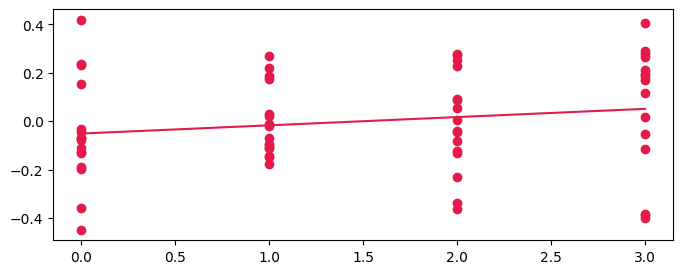

failure interval length (FL): slope: [4.16569087] intercept: -6.248536298975124


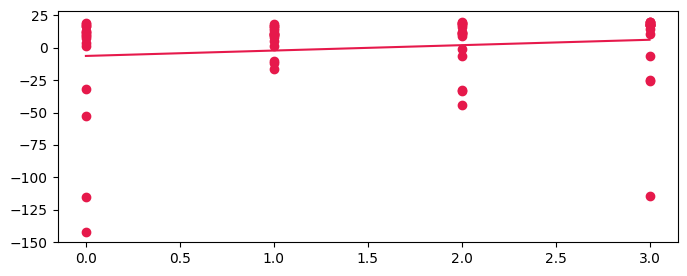

failure count (FC): slope: [-1.14375] intercept: 1.7156249999999997


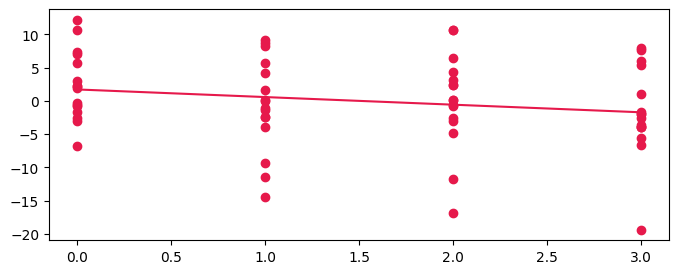

Note that the outliers can drastially change the trend here... see especially plot 2 (FL).

### Tentative conclusion:
 It seems that there is a little improvement over time for FP and FL, but that there is a decrease in FC. Essentially, people went into failure more but they stayed in failure for less total time.

__NEXT STEPS?__ remove outliers and see if the trends still hold?

In [4]:

# LINEAR REGRESSION OF CORRECTED SCORES

markdown("""## Regressing Corrected Scores:\n Depending on the performance measure we either see a slight improvement or we don't. 
         I think it is safe to say that the participants didn't improve with time.""")

def plot_regression(score, title=None):
    fig = plt.figure(figsize=(8,3))
    from sklearn.linear_model import LinearRegression
    ncols = score.score_corrected.select_dtypes(include='number').columns
    df = score.score_corrected[ncols].melt(var_name='X', value_name='Y')
    # Create an instance of the LinearRegression model
    x, y = df['X'].to_numpy(), df['Y'].to_numpy()
    model = LinearRegression()
    model.fit(x[:,np.newaxis], y)
    slope = model.coef_
    intercept = model.intercept_
    print(f"{title}: slope: {slope} intercept: {intercept}")
    plt.gca().scatter(x,y, color="#e6194B")
    x_line = np.linspace(np.min(x), np.max(x), 100)
    plt.gca().plot(x_line, slope * x_line + intercept, color="#e6194B")
    plt.show()
    
plot_regression(score_fp, title="failure proportion (FP)")
plot_regression(score_il, title="failure interval length (FL)")
plot_regression(score_fc, title="failure count (FC)")

markdown("Note that the outliers can drastially change the trend here... see especially plot 2 (FL).")

markdown("### Tentative conclusion:\n It seems that there is a little improvement over time for FP and FL, but that there is a decrease in FC. Essentially, people went into failure more but they stayed in failure for less total time.")

markdown("__NEXT STEPS?__ remove outliers and see if the trends still hold?")

#### Correlation between estimated and actual performance
 This might give some indiciation of which performance measure is a good one if we assume that the participants are reasonably good at judging their own performance.

Overall Correlation: 0.6381


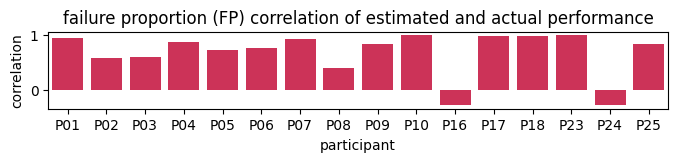

Overall Correlation: 0.1083


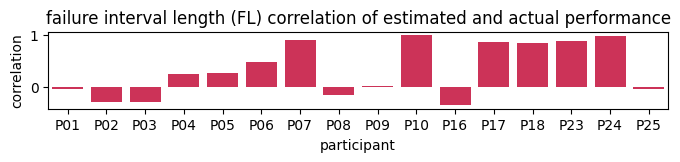

Overall Correlation: 0.0713


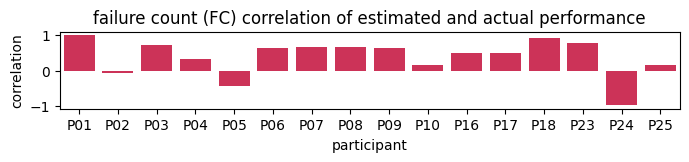

In [5]:
# visualises performance against perceived difficulty 
# Q: did the participants accurately judge difficulty? 
# A: yes, most of them except P16 and P24. Interestingly these are two of the worst performers (especially 24)

# P16, icuaA, icuB, icuaB, icuA,  moderate, easy,     moderate, veasy
# P24, icuaA, icuB, icuA,  icuaB, hard,     moderate, moderate, moderate
# what was P16 doing?

def estimated_performance_correlation(failure_statistic, title=None):
    data = load_nested_dict('data/Processed') 
    df_p = compute_failure_interval_statistics(data, failure_statistic)
    df_p = df_p[['participant', 'experiment', 'total']]
    df_p = df_p.pivot(index='participant', columns='experiment', values='total')
    exp = df_p.reset_index(drop=True).select_dtypes(include="number").columns.to_list()
    df_demo = get_demographics_data()
    df_p = df_p.reset_index()
    def order_scores(df_p):
        for (i, drow), (i, prow) in zip(df_demo[['participant',0,1,2,3]].iterrows(), df_p.iterrows()):
            assert drow['participant'] == prow['participant']
            drow = drow.to_list()        
            yield [drow[0]] + [prow[i] for i in drow[1:]] # reorder
    df_score = pd.DataFrame(order_scores(df_p), columns=['participant',0,1,2,3])
    df_score = df_score.melt(id_vars='participant', var_name='experiment', value_name='score')
    df_score = df_score.reset_index(drop=True)
    df_demo = df_demo[['participant','S0','S1','S2','S3']].rename(columns={'S0':0,'S1':1,'S2':2,'S3':3})
    df_demo = df_demo.melt(id_vars='participant', var_name='experiment', value_name='estimate')
    ests = ['veasy', 'easy', 'moderate', 'hard']
    ests = {ests[i]:i for i in range(len(ests))}
    df_demo = df_demo.replace(ests) # replace with numeric values so we can compute correlations
    df_m = pd.merge(df_score, df_demo, on=['participant', 'experiment'])
    print(f"Overall Correlation: {df_m['score'].corr(df_m['estimate']):.4f}")

    grouped_df = df_m.groupby('participant')[['score', 'estimate']].corr().reset_index()
    grouped_df = grouped_df.loc[::2][['participant', 'estimate']]
    grouped_df = grouped_df.rename(columns={'estimate':'correlation'})

    fig = plt.figure(figsize=(8,1))

    ax = sns.barplot(x='participant', y='correlation', data=grouped_df, color="#e6194B")
    ax.set_title(f"{title} correlation of estimated and actual performance")
    plt.show()
    #fig = plt.figure(figsize=(24,4))
    #df_sorted = df_m.sort_values('participant').reset_index(drop=True)
    #sns.heatmap(MinMaxScaler().fit_transform(df_sorted[['score','estimate']]).T, cmap='coolwarm',)

markdown("#### Correlation between estimated and actual performance\n This might give some indiciation of which performance measure is a good one if we assume that the participants are reasonably good at judging their own performance.")
estimated_performance_correlation(Statistics.compute_failure_proportion,   title="failure proportion (FP)")
estimated_performance_correlation(Statistics.compute_mean_interval_length, title="failure interval length (FL)")
estimated_performance_correlation(Statistics.compute_failure_count,        title="failure count (FC)")






## Did agents help?
 According to participants, they found it slightly more difficult with the agents assistance.

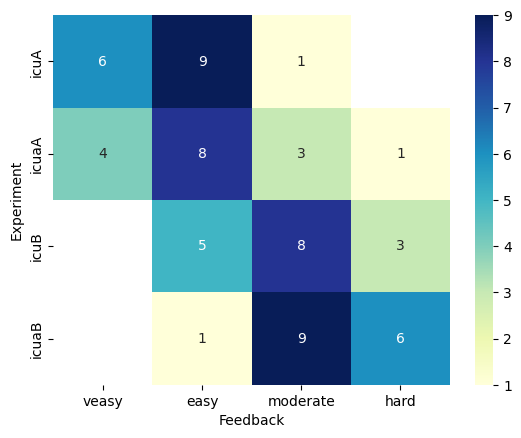

In [6]:
# Visualises actual difficulty and perceived difficulty (via feedback).
# It looks like the agents made things slightly worse here...

markdown("## Did agents help?\n According to participants, they found it slightly more difficult with the agents assistance.")
df = get_demographics_data()
counts_df = pd.DataFrame(np.concatenate([df[[i, f'S{i}']].to_numpy() for i in range(4)], axis=0))
pd.set_option("display.max_rows", 1000)
counts_df = pd.DataFrame(counts_df.value_counts()).reset_index()
# Pivot the dataframe to create a matrix-like structure
heatmap_data = counts_df.pivot(columns=1, index=0, values='count')
heatmap_data.fillna(0)
heatmap_data = heatmap_data[['veasy', 'easy', 'moderate', 'hard']]
heatmap_data = heatmap_data.reindex(['icuA','icuaA','icuB', 'icuaB'])
# Create the heatmap using seaborn
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
# Set the labels for the x-axis and y-axis
plt.xlabel('Feedback')
plt.ylabel('Experiment')
# Display the heatmap
plt.show()
